In [1]:
import subprocess
from pathlib import Path

from IPython.display import Image, Video

from data_loading import load_annotated_6k_collection

In [2]:
tfs = load_annotated_6k_collection()

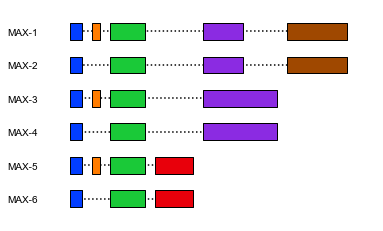

In [3]:
# get exon colors
gene = tfs['MAX']
gene.exon_diagram()

In [6]:
gene['MAX-1'].exons

[Exon of MAX|1/6|08G02 36 nt,
 Exon of MAX|1/6|08G02 27 nt,
 Exon of MAX|1/6|08G02 108 nt,
 Exon of MAX|1/6|08G02 124 nt,
 Exon of MAX|1/6|08G02 185 nt]

In [13]:
isoforms_with_structure

[Clone acc: MAX|1/6|08G02
 Isoform: MAX-205 / ENSP00000351490 / ENST00000358664
 length: 160 aa,
 Clone acc: MAX|3/6|08E02
 Isoform: MAX-202 / ENSP00000284165 / ENST00000284165
 length: 134 aa,
 Clone acc: MAX|4/6|08A03
 Isoform: MAX-213 / ENSP00000450818 / ENST00000556443
 length: 125 aa]

In [17]:

def compare_isoform_structures(gene,
                               fname,
                               n_pixel_height=1000,
                               n_frames=50,
                               frame_rate=10,
                               verbose=False):
    structure_dir = Path('../../data/internal/alphafold/reduced_dbs')
    pymol_script_dir = Path('/tmp/pymol_scripts')
    pymol_script_dir.mkdir(exist_ok=True)
    pymol_script_path = pymol_script_dir / '{}_alphafold_cloned_isoforms.pml'.format(gene.name)
    isoforms_with_structure = []
    with open(pymol_script_path, 'w') as f:
        f.write('reinitialize\n')
        f.write('bg_color white\n')
        for isoform in gene.orfs:
            fpath = structure_dir / (isoform.name + '/ranked_0.pdb')
            if not fpath.exists():
                continue
            isoforms_with_structure.append(isoform)
            f.write('load {}, {}\n'.format(fpath, isoform.name.replace('-', '_')))
            if isoform.name != gene.orfs[0].name:
                f.write('align {}, {}\n'.format(isoform.name.replace('-', '_'),
                                                gene.orfs[0].name.replace('-', '_')))
            exon_colors = gene._get_exon_colors()
            exon_pos = 1
            nt_diff = 0
            for exon in isoform.exons:
                n_nt_to_exon = (exon.end - exon.start) + nt_diff
                n_aa_exon = round(n_nt_to_exon / 3)
                nt_diff = {0: 0, 1: 1, 2: -1}[n_nt_to_exon % 3]
                color = exon_colors[(isoform.name, exon.start, exon.end)]
                start = exon_pos
                end = (exon_pos + n_aa_exon) - 1
                color_name = isoform.name + '_' + str(exon.start) + '_color'
                f.write('set_color {}, {}\n'.format(color_name, color))
                f.write('color {}, {} AND resi {}-{}\n'.format(color_name,
                                                            isoform.name.replace('-', '_'),
                                                            start,
                                                            end))
                exon_pos += n_aa_exon

        f.write('set grid_mode, 1\n')
        for i, isoform in enumerate(isoforms_with_structure):
            f.write('set grid_slot, {}, {}\n'.format(i + 1, isoform.name.replace('-', '_')))

        f.write('refresh\n')  # need refresh otherwise grid mode doesn't work
        f.write('viewport {}, {}\n'.format(n_pixel_height * len(isoforms_with_structure), n_pixel_height))
        f.write('zoom\n')
        f.write('set ray_trace_frames, 1\n')
        f.write('mset 1-{}\n'.format(n_frames))
        f.write("movie.roll\n")
        f.write('mplay\n')
        f.write('mpng /tmp/movie\n')
    ret = subprocess.run('pymol -c {}'.format(pymol_script_path),
                         capture_output=True,
                         shell=True)
    if verbose:
        print(ret.stdout.decode())
        print(ret.stderr.decode())
    cmd = 'ffmpeg -y -r {} -f image2 -i /tmp/movie%04d.png -c:v libx264 -pix_fmt yuv420p {}'.format(frame_rate, fname)
    ret = subprocess.run(cmd, capture_output=True, shell=True)
    if verbose:
        print(ret.stdout.decode())
        print(ret.stderr.decode())

compare_isoform_structures(gene=tfs['MAX'], fname='/tmp/my_movie.mp4')
Video('/tmp/my_movie.mp4')

In [ ]:
gene_name = 'GATA2'
tfs[gene_name].exon_diagram()
#compare_isoform_structures(gene=tfs[gene_name], fname='../../figures/alphafold/videos/{}.mp4'.format(gene_name))